## Tests of time evolution integrators

This notebook contains tests for the time evolution integrators: \
Crank-Nicolson integrator: unitarity & energy conservation \
Strang-splitting integrator: unitarity


We shall first import the functions form the functions.py script, where all the relevant functions are defined and described.

In [8]:
import functions
from functions import *
rng = functions.rng
# Import for pretty print
from termcolor import colored

### test for unitarity of the Crank-Nicolson integrator

To test for unitarity, we first need to define the adjoint Crank-Nicolson integrator. This is trivially derived from the implementation of the Crank-Nicolson integrator by swapping the term to be inverted with the second term :

In [9]:
def adjoint_crank_nicolson(psi:np.ndarray, time_step: float, hamiltonian:callable, conjugate_gradient_tolerance= 1.e-10, max_iters_conjugate_gradient= 1000):

    def inversion_term(psi):
        """Term to be inverted by conjugate gradient"""
        return psi-(1j/2)*time_step*hamiltonian(psi)+0.25*time_step**2*hamiltonian(hamiltonian(psi))
    eta = conjugate_gradient(inversion_term,psi, epsilon=conjugate_gradient_tolerance, max_iters=max_iters_conjugate_gradient)
    psi_evolved = eta+0.25*time_step**2*hamiltonian(hamiltonian(eta))
    return psi_evolved

To verify the properties of the integrators we have implemented in our code, we shall test through iterations of random inputs and parameters.\
Input wavefunctions shall be randomized for given set of parameters. In particular it is of interest to test the integrators for several dimensions as well as resolution of the lattice and parameters of the potential.\
We shall test for the following parameters:

N= 1 ... 100 \
D= 1 ... 3\
$\mu$= 0.1 ... 100\
$\varepsilon^{2}$ = 0.001 ... 1

In [13]:
stats_latticepoints = []
stats_accuracy = []
for i in range(1,3):
    for j in range(0,3):
        for k in range(-1,3):
            for l in range(-3,1):
                 # Set parameters in the current environemnt                
                D = i
                N= 10**j
                mu = 10**k
                epsilon_2 = 10**l
                
                # Collect stats
                stats_latticepoints.append(N**D)

                # Set global parameters in the functions environment
                functions.N = N
                functions.D = D
                functions.mu = mu
                functions.epsilon_2 = epsilon_2

                # Caluculate potential for given parameters
                functions.potential_array = potential_array_calculator()

                potential_height = 1
                functions.potential_array = potential_array_calculator()
                functions.kinetic_energy_array = kinetic_energy_array_calculator()
                # Generate random wavefunctions as complex arrays
                psi = generate_complex_ndarray(N,D)
                time_step =  0.000005
                apply_original_adjoint = adjoint_crank_nicolson(integrator_crank_nicolson(psi, time_step, hamiltonian_function, max_iters_conjugate_gradient=1000), time_step, hamiltonian_function)

                # This precision has only technical reason, no physical meaning
                relative_tolerance= 1.e-30
                try:
                    # Assert two terms are equal    
                    np.testing.assert_allclose(psi, apply_original_adjoint, atol = 0, rtol=relative_tolerance, err_msg=str, verbose=False)
                except AssertionError as e:    
                    print(colored(fr"""The test of unitarity passed  with {str(e).splitlines()[-1]} for parameters:
D={D} N={N} mu={mu} epsilon_2={epsilon_2}""", "green"))
                    stats_accuracy.append(float( str(e).splitlines()[-1].split(":")[1].strip()))                    
                else:
                    print(colored(fr"""The test of unitarity passed with relative precision greater than {relative_tolerance} for parameters:
D={D} N={N} mu={mu} epsilon_2={epsilon_2}""", 'green'))  
                    stats_accuracy.append(relative_tolerance)

                

The test of unitarity passed  with Max relative difference: 2.00677865e-15 for parameters:
D=1 N=1 mu=0.1 epsilon_2=0.001
The test of unitarity passed  with Max relative difference: 1.9520831e-15 for parameters:
D=1 N=1 mu=0.1 epsilon_2=0.01
The test of unitarity passed  with Max relative difference: 1.85642783e-15 for parameters:
D=1 N=1 mu=0.1 epsilon_2=0.1
The test of unitarity passed  with Max relative difference: 1.77318765e-15 for parameters:
D=1 N=1 mu=0.1 epsilon_2=1
The test of unitarity passed  with Max relative difference: 1.95319492e-13 for parameters:
D=1 N=1 mu=1 epsilon_2=0.001
The test of unitarity passed  with Max relative difference: 1.95396035e-13 for parameters:
D=1 N=1 mu=1 epsilon_2=0.01
The test of unitarity passed  with Max relative difference: 1.95558496e-13 for parameters:
D=1 N=1 mu=1 epsilon_2=0.1
The test of unitarity passed  with Max relative difference: 1.952262e-13 for parameters:
D=1 N=1 mu=1 epsilon_2=1
The test of unitarity passed  with Max relative d

We observe the tests generally pass, with the exception of timeouts in the conjugate gradient. The unitarity of the Crank-Nicolson operator is therefore directly dependent on the accuracy of the conjugate gradient function.\
We visualize the accuracy of the unitarity tests:

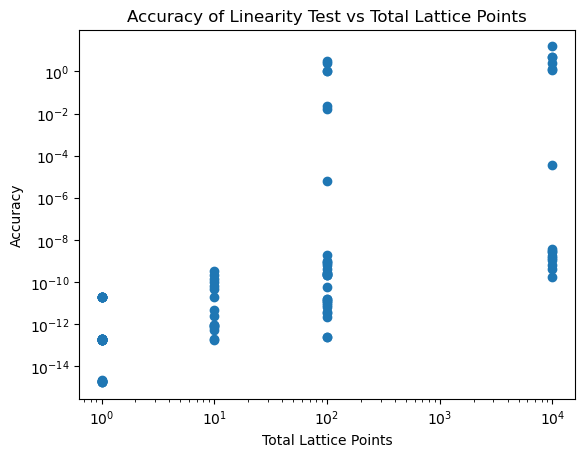

In [14]:
plt.plot(stats_latticepoints, stats_accuracy, 'o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Total Lattice Points')
plt.ylabel('Accuracy')
plt.title('Accuracy of Linearity Test vs Total Lattice Points')
plt.show()

### Test of energy conservation of the Crank-Nicolson integrator

To verify the Crank-Nicolson integrator conserves energy, we shall proove the following equation:\
$\hat{U}^{\dagger}_{cn} \hat{H}\hat{U}_{cn} = \hat{H}$\
where $\hat{U}_{cn}$ is the Crank-Nicolson integrator.

In [15]:
stats_latticepoints = []
stats_accuracy = []
for i in range(1,3):
    for j in range(0,3):
        for k in range(-1,3):
            for l in range(-3,1):
                 # Set parameters in the current environemnt                
                D = i
                N= 10**j
                mu = 10**k
                epsilon_2 = 10**l
                
                # Collect stats
                stats_latticepoints.append(N**D)

                # Set global parameters in the functions environment
                functions.N = N
                functions.D = D
                functions.mu = mu
                functions.epsilon_2 = epsilon_2

                # Caluculate potential for given parameters
                functions.potential_array = potential_array_calculator()
                functions.kinetic_energy_array = kinetic_energy_array_calculator()
                # Generate random wavefunctions as complex arrays
                psi = generate_complex_ndarray(N,D)
                time_step =  0.000005
                hamiltonian_psi = hamiltonian_function(psi)
                apply_crank_nicolson = integrator_crank_nicolson(psi, time_step, hamiltonian_function, max_iters_conjugate_gradient=1000)
                apply_hamiltonian = hamiltonian_function(apply_crank_nicolson)
                apply_adjoint_crank_nicolson = adjoint_crank_nicolson(apply_hamiltonian, time_step, hamiltonian_function)

                # This precision has only technical reason, no physical meaning
                relative_tolerance= 1.e-30
                try:
                    # Assert two terms are equal    
                    np.testing.assert_allclose(hamiltonian_psi, apply_adjoint_crank_nicolson, atol = 0, rtol=relative_tolerance, err_msg=str, verbose=False)
                except AssertionError as e:    
                    print(colored(fr"""The test of unitarity passed  with {str(e).splitlines()[-1]} for parameters:
D={D} N={N} mu={mu} epsilon_2={epsilon_2}""", "green"))
                    stats_accuracy.append(float( str(e).splitlines()[-1].split(":")[1].strip()))                    
                else:
                    print(colored(fr"""The test of unitarity passed with relative precision greater than {relative_tolerance} for parameters:
D={D} N={N} mu={mu} epsilon_2={epsilon_2}""", 'green'))  
                    stats_accuracy.append(relative_tolerance)    

The test of unitarity passed  with Max relative difference: 1.91657291e-15 for parameters:
D=1 N=1 mu=0.1 epsilon_2=0.001
The test of unitarity passed  with Max relative difference: 1.85286346e-15 for parameters:
D=1 N=1 mu=0.1 epsilon_2=0.01
The test of unitarity passed  with Max relative difference: 1.78836614e-15 for parameters:
D=1 N=1 mu=0.1 epsilon_2=0.1
The test of unitarity passed  with Max relative difference: 2.06667934e-15 for parameters:
D=1 N=1 mu=0.1 epsilon_2=1
The test of unitarity passed  with Max relative difference: 1.95497861e-13 for parameters:
D=1 N=1 mu=1 epsilon_2=0.001
The test of unitarity passed  with Max relative difference: 1.95313484e-13 for parameters:
D=1 N=1 mu=1 epsilon_2=0.01
The test of unitarity passed  with Max relative difference: 1.95277312e-13 for parameters:
D=1 N=1 mu=1 epsilon_2=0.1
The test of unitarity passed  with Max relative difference: 1.95425411e-13 for parameters:
D=1 N=1 mu=1 epsilon_2=1
The test of unitarity passed  with Max relativ

We observe the tests generally pass, with the exception of timeouts in the conjugate gradient. As such, the energy conservation of the Crank-Nicolson operator is dependent on the accuracy of the conjugate gradient function.\
We visualize the accuracy of the unitarity tests:

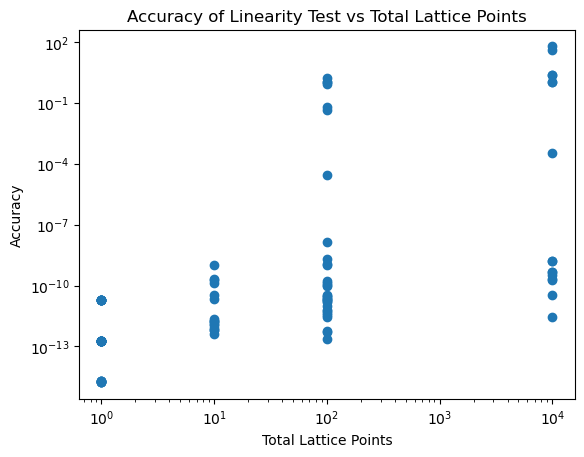

In [16]:
plt.plot(stats_latticepoints, stats_accuracy, 'o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Total Lattice Points')
plt.ylabel('Accuracy')
plt.title('Accuracy of Linearity Test vs Total Lattice Points')
plt.show()

## Test for unitarity of the Strang-splitting integrator

For this test, we need to define the adjoint Strang-splitting integrator:


In [22]:
# def adjoint_strang_splitting(psi:np.ndarray, time_step: float, hamiltonian):
#     global N, D, mu, epsilon, potential_array, kinetic_energy_array    

#     eta_real = np.exp(0.5j*time_step*potential_array)*psi
#     eta_freq = np.fft.fft(eta_real)    
#     xi_freq = np.exp(1j*time_step*kinetic_energy_array)*eta_freq
#     xi_real = np.fft.ifft(xi_freq)
#     psi_evolved = np.exp(0.5j*time_step*potential_array)*xi_real
#     return psi_evolved
def adjoint_strang_splitting(psi:np.ndarray, time_step: float, hamiltonian):
    global N, D, mu, epsilon, potential_array, kinetic_energy_array    

    eta_real = np.exp(0.5j*time_step*potential_array)*psi
    eta_real_flat = eta_real.ravel()
    eta_freq_flat = np.fft.fft(eta_real_flat)
    eta_freq =  eta_freq_flat.reshape(eta_real.shape)   
    xi_freq = np.exp(1j*time_step*kinetic_energy_array)*eta_freq
    xi_feq_flat =xi_freq.ravel()
    xi_real_flat = np.fft.ifft(xi_feq_flat)
    xi_real =  xi_real_flat.reshape(eta_real.shape) 
    psi_evolved = np.exp(0.5j*time_step*potential_array)*xi_real
    return psi_evolved

In [24]:
stats_latticepoints = []
stats_accuracy = []
for i in range(1,3):
    for j in range(0,3):
        for k in range(-1,3):
            for l in range(-3,1):
                 # Set parameters in the current environemnt                
                D = i
                N= 10**j
                mu = 10**k
                epsilon_2 = 10**l
                
                # Collect stats
                stats_latticepoints.append(N**D)

                # Set global parameters in the functions environment
                functions.N = N
                functions.D = D
                functions.mu = mu
                functions.epsilon_2 = epsilon_2

                # Caluculate potential for given parameters
                potential_array = potential_array_calculator()
                functions.potential_array = potential_array
                kinetic_energy_array = kinetic_energy_array_calculator()
                functions.kinetic_energy_array = kinetic_energy_array

                

                # Generate random wavefunctions as complex arrays
                psi = generate_complex_ndarray(N,D)
                time_step =  0.000005
                apply_original_adjoint = adjoint_strang_splitting(integrator_strang_splitting(psi, time_step, hamiltonian_function), time_step, hamiltonian_function)
                # This precision has only technical reason, no physical meaning
                relative_tolerance= 1.e-30
                print(psi.shape)
                try:
                    # Assert two terms are equal    
                    np.testing.assert_allclose(psi, apply_original_adjoint, atol = 0, rtol=relative_tolerance, err_msg=str, verbose=False)
                except AssertionError as e:    
                    print(colored(fr"""The test of unitarity passed  with {str(e).splitlines()[-1]} for parameters:
D={D} N={N} mu={mu} epsilon_2={epsilon_2}""", "green"))
                    stats_accuracy.append(float( str(e).splitlines()[-1].split(":")[1].strip()))                    
                else:
                    print(colored(fr"""The test of unitarity passed with relative precision greater than {relative_tolerance} for parameters:
D={D} N={N} mu={mu} epsilon_2={epsilon_2}""", 'green'))  
                    stats_accuracy.append(relative_tolerance) 

(1,)
The test of unitarity passed  with (shapes (1,), (100, 100) mismatch) for parameters:
D=1 N=1 mu=0.1 epsilon_2=0.001


IndexError: list index out of range

In [ ]:
plt.plot(stats_latticepoints, stats_accuracy, 'o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Total Lattice Points')
plt.ylabel('Accuracy')
plt.title('Accuracy of Linearity Test vs Total Lattice Points')
plt.show()